In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_relationships.csv', 'train', 'sample_submission.csv']


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-8msbnhsz
  Stored in directory: /tmp/pip-ephem-wheel-cache-3tsj0u4n/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gc
import cv2
import glob
from keras_vggface.utils import preprocess_input

def read_img(path):
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img,version=2)

Using TensorFlow backend.


In [4]:
from collections import defaultdict
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob("../input/train/*"):
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.keys())
len(ppl)

2316

In [5]:
data = pd.read_csv('../input/train_relationships.csv')
data.p1 = data.p1.apply( lambda x: '../input/train/'+x )
data.p2 = data.p2.apply( lambda x: '../input/train/'+x )
print(data.shape)
data.head()

(3598, 2)


,p1,p2
0,../input/train/F0002/MID1,../input/train/F0002/MID3
1,../input/train/F0002/MID2,../input/train/F0002/MID3
2,../input/train/F0005/MID1,../input/train/F0005/MID2
3,../input/train/F0005/MID3,../input/train/F0005/MID2
4,../input/train/F0009/MID1,../input/train/F0009/MID4


In [6]:
data = data[ ( (data.p1.isin(ppl)) & (data.p2.isin(ppl)) ) ]
data = [ ( x[0], x[1]  ) for x in data.values ]
len(data)

3362

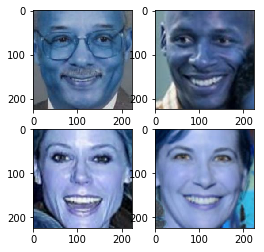

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, sample

f, ax = plt.subplots(2, 2, figsize=(4, 4))
batch = sample(data,2)
for i,j in [(0,0),(0,1),(1,0),(1,1)]:
    ax[i][j].imshow( cv2.imread( choice(allPhotos[batch[i][j]]) ) )

In [8]:
train = [ x for x in data if 'F09' not in x[0]  ]
val = [ x for x in data if 'F09' in x[0]  ]
len(train), len(val)

(3066, 296)

In [9]:
def getImages(p1,p2):
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
    p1 = []; p2 = []; Y = []
    batch = sample(data, batch_size//2)
    for x in batch:
        _p1, _p2 = getImages(*x)
        p1.append(_p1);p2.append(_p2);Y.append(1)
    while len(Y) < batch_size:
        _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
        if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
            _p1,_p2 = getImages(_p1,_p2)
            p1.append(_p1);p2.append(_p2);Y.append(0) 
    return [np.array(p1),np.array(p2)], np.array(Y)

In [10]:
from keras_vggface.vggface import VGGFace

IMG_DIM = (224,224,3)

vggface = VGGFace(model='resnet50', include_top=False)

for layer in vggface.layers[:-3]:
    layer.trainable=True

Instructions for updating:
Colocations handled automatically by placer.
94699520/94694792 [==============================] - 1s 0us/step


In [11]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [12]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model 
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.2)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [13]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = siamese_net.fit_generator( train_gen, samples_per_epoch=200, epochs=100, 
                          validation_data=val_gen, validation_steps=100, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list, workers=4)

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=100, validation_data=<generator..., validation_steps=100, use_multiprocessing=True, verbose=1, callbacks=[<keras.ca..., workers=4, steps_per_epoch=200)`


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



200/200 [==============================] - 98s 488ms/step - loss: 0.7493 - acc: 0.5284 - auc: 0.5453 - val_loss: 0.6762 - val_acc: 0.6338 - val_auc: 0.7280

Epoch 00001: val_auc improved from -inf to 0.72797, saving model to model_best_checkpoint.h5
Epoch 2/100
200/200 [==============================] - 71s 353ms/step - loss: 0.6848 - acc: 0.6150 - auc: 0.6715 - val_loss: 0.6493 - val_acc: 0.6412 - val_auc: 0.7347

Epoch 00002: val_auc improved from 0.72797 to 0.73469, saving model to model_best_checkpoint.h5
Epoch 3/100
200/200 [==============================] - 71s 356ms/step - loss: 0.6219 - acc: 0.6875 - auc: 0.7587 - val_loss: 0.6542 - val_acc: 0.6475 - val_auc: 0.7358

Epoch 00003: val_auc improved from 0.73469 to 0.73578, saving model to model_best_checkpoint.h5
Epoch 4/100
200/200 [==============================] - 71s 355ms/step - loss: 0.6086 - acc: 0.6972 - auc: 0.7825 - val_loss: 0.6004 - val_acc: 0.7031 - val_auc: 0.8255

Epoch 00004: val_auc improved from 0.73578 to 0.82

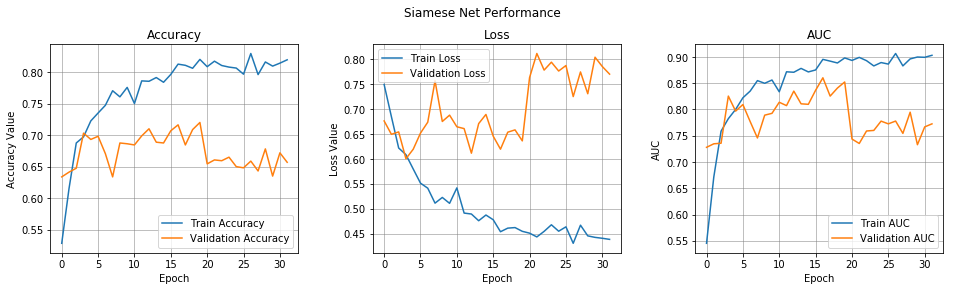

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [15]:
siamese_net.load_weights('model_best_checkpoint.h5')

In [24]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['p1'] = submission.img_pair.apply( lambda x: '../input/test/'+x.split('-')[0] )
submission['p2'] = submission.img_pair.apply( lambda x: '../input/test/'+x.split('-')[1] )
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,../input/test/face05508.jpg,../input/test/face01210.jpg
1,face05750.jpg-face00898.jpg,0,../input/test/face05750.jpg,../input/test/face00898.jpg
2,face05820.jpg-face03938.jpg,0,../input/test/face05820.jpg,../input/test/face03938.jpg
3,face02104.jpg-face01172.jpg,0,../input/test/face02104.jpg,../input/test/face01172.jpg
4,face02428.jpg-face05611.jpg,0,../input/test/face02428.jpg,../input/test/face05611.jpg


In [25]:
from tqdm import tqdm
probs = []
for i,j in tqdm([ (0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),
                 (2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,5000),(5000,5310) ]):
    imgs1 = np.array( [ read_img(photo) for photo in submission.p1.values[i:j] ] )
    imgs2 = np.array( [ read_img(photo) for photo in submission.p2.values[i:j] ] )
    prob =  siamese_net.predict( [ imgs1, imgs2 ] )
    probs.append(np.squeeze(prob))
    del imgs1,imgs2; gc.collect()

100%|██████████| 11/11 [01:23<00:00,  6.76s/it]


In [26]:
submission.is_related = np.concatenate(probs)
submission.drop( ['p1','p2'],axis=1,inplace=True )
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.159218
1,face05750.jpg-face00898.jpg,0.780466
2,face05820.jpg-face03938.jpg,0.179558
3,face02104.jpg-face01172.jpg,0.543935
4,face02428.jpg-face05611.jpg,0.499807


In [27]:
submission.to_csv('submission.csv',index=False)